In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import glob
from transformers import AutoTokenizer, AutoModel
from rouge_score import rouge_scorer
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
# Paths
judgement_path = "/kaggle/input/summaries/IN-Ext/judgement"
summary_path = "/kaggle/input/summaries/IN-Ext/summary/segment-wise/A1"

# Load judgements and summaries with error handling
def load_dataset_from_paths(judgement_dir, summary_dir, max_files=None):
    """Load judgements and their reference summaries"""
    dataset = []
    
    # Get all judgement files
    judgement_files = sorted(glob.glob(os.path.join(judgement_dir, "*.txt")))
    
    if max_files:
        judgement_files = judgement_files[:max_files]
    
    print(f"Found {len(judgement_files)} judgement files")
    
    for jfile in tqdm(judgement_files, desc="Loading files"):
        filename = os.path.basename(jfile)
        file_id = filename.replace('.txt', '')
        
        # Read judgement with multiple encoding attempts
        judgment_text = None
        for encoding in ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']:
            try:
                with open(jfile, 'r', encoding=encoding, errors='ignore') as f:
                    judgment_text = f.read()
                break
            except:
                continue
        
        if not judgment_text:
            print(f"Warning: Could not read {filename}, skipping...")
            continue
        
        # Read reference summaries (if available)
        reference_summaries = {}
        for aspect in ['facts', 'analysis', 'argument', 'judgement', 'statute']:
            summary_file = os.path.join(summary_dir, aspect, filename)
            if os.path.exists(summary_file):
                # Try multiple encodings
                for encoding in ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']:
                    try:
                        with open(summary_file, 'r', encoding=encoding, errors='ignore') as f:
                            reference_summaries[aspect] = f.read().strip()
                        break
                    except:
                        continue
        
        dataset.append({
            'judgment_file': filename,
            'judgment': judgment_text,
            'reference_summaries': reference_summaries
        })
    
    return dataset

# Load dataset
print("Loading dataset...")
full_dataset = load_dataset_from_paths(judgement_path, summary_path)
print(f"✓ Loaded {len(full_dataset)} documents with reference summaries")

# Check how many have reference summaries
aspects_count = {aspect: 0 for aspect in ['facts', 'analysis', 'argument', 'judgement', 'statute']}
for item in full_dataset:
    for aspect in aspects_count.keys():
        if aspect in item['reference_summaries']:
            aspects_count[aspect] += 1

print("\nReference summaries available:")
for aspect, count in aspects_count.items():
    print(f"  {aspect}: {count}/{len(full_dataset)} documents")

# Randomly select 20 documents for evaluation
num_test = min(20, len(full_dataset))
test_data = random.sample(full_dataset, num_test)
print(f"\n✓ Selected {len(test_data)} documents for evaluation")


Loading dataset...
Found 50 judgement files


Loading files: 100%|██████████| 50/50 [00:02<00:00, 22.09it/s]

✓ Loaded 50 documents with reference summaries

Reference summaries available:
  facts: 50/50 documents
  analysis: 50/50 documents
  argument: 46/50 documents
  judgement: 50/50 documents
  statute: 41/50 documents

✓ Selected 20 documents for evaluation


In [3]:
class SentenceEncoder(nn.Module):
    def __init__(self, model_name="law-ai/InLegalBERT", hidden_dim=768):
        super(SentenceEncoder, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.hidden_dim = hidden_dim
        # Freeze encoder
        for param in self.model.parameters():
            param.requires_grad = False
    
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def forward(self, sentences):
        encoded = self.tokenizer(sentences, padding=True, truncation=True, max_length=512, return_tensors='pt')
        encoded = {k: v.to(device) for k, v in encoded.items()}
        with torch.no_grad():
            model_output = self.model(**encoded)
            embeddings = self.mean_pooling(model_output, encoded['attention_mask'])
        return embeddings

print("✓ SentenceEncoder class defined")


✓ SentenceEncoder class defined


In [4]:
class ImprovedReferenceFreeReward:
    def __init__(self, encoder):
        self.encoder = encoder
    
    def compute_coherence(self, summary_sentences):
        if len(summary_sentences) < 2:
            return 1.0
        embeddings = self.encoder(summary_sentences)
        coherence_scores = []
        for i in range(len(embeddings) - 1):
            sim = torch.nn.functional.cosine_similarity(
                embeddings[i].unsqueeze(0), embeddings[i+1].unsqueeze(0)
            )
            coherence_scores.append(sim.item())
        return np.mean(coherence_scores) if coherence_scores else 0.0
    
    def compute_coverage(self, summary_embeddings, document_embeddings):
        coverage_scores = []
        for doc_emb in document_embeddings:
            sims = torch.nn.functional.cosine_similarity(
                doc_emb.unsqueeze(0).expand(len(summary_embeddings), -1),
                summary_embeddings
            )
            coverage_scores.append(sims.max().item())
        return np.mean(coverage_scores)
    
    def compute_redundancy(self, summary_embeddings):
        if len(summary_embeddings) < 2:
            return 0.0
        redundancy_scores = []
        for i in range(len(summary_embeddings)):
            for j in range(i+1, len(summary_embeddings)):
                sim = torch.nn.functional.cosine_similarity(
                    summary_embeddings[i].unsqueeze(0), summary_embeddings[j].unsqueeze(0)
                )
                redundancy_scores.append(sim.item())
        return np.mean(redundancy_scores) if redundancy_scores else 0.0
    
    def compute_diversity(self, summary_embeddings):
        if len(summary_embeddings) < 2:
            return 0.0
        distances = []
        for i in range(len(summary_embeddings)):
            for j in range(i+1, len(summary_embeddings)):
                dist = 1.0 - torch.nn.functional.cosine_similarity(
                    summary_embeddings[i].unsqueeze(0), summary_embeddings[j].unsqueeze(0)
                ).item()
                distances.append(dist)
        return np.mean(distances) if distances else 0.0
    
    def compute_informativeness(self, summary_embeddings, document_embeddings):
        informativeness_scores = []
        for summ_emb in summary_embeddings:
            sims = torch.nn.functional.cosine_similarity(
                summ_emb.unsqueeze(0).expand(len(document_embeddings), -1),
                document_embeddings
            )
            informativeness_scores.append(sims.mean().item())
        return np.mean(informativeness_scores)

print("✓ ImprovedReferenceFreeReward class defined")


✓ ImprovedReferenceFreeReward class defined


In [5]:
class MultiAspectPolicyNetwork(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_aspects=5, dropout=0.5, max_position=2000):
        super(MultiAspectPolicyNetwork, self).__init__()
        self.num_aspects = num_aspects
        self.aspects = ['facts', 'analysis', 'argument', 'judgement', 'statute']
        self.hidden_dim = hidden_dim
        self.max_position = max_position
        
        # Shared LSTM encoder
        self.shared_lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, bidirectional=True, 
                                   batch_first=True, dropout=dropout)
        
        # Position and aspect embeddings - NOW CONFIGURABLE
        self.position_embedding = nn.Embedding(max_position, 64)
        self.aspect_embedding = nn.Embedding(num_aspects, hidden_dim * 2)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2, num_heads=4, 
                                              dropout=dropout, batch_first=True)
        
        # Aspect-specific heads
        self.aspect_heads = nn.ModuleDict()
        for aspect in self.aspects:
            self.aspect_heads[aspect] = nn.Sequential(
                nn.Linear((hidden_dim * 2 + 64 + hidden_dim * 2), 512),
                nn.LayerNorm(512),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(512, 256),
                nn.LayerNorm(256),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(256, 1)
            )
    
    def forward(self, sentence_embeddings, positions, aspect_idx):
        # LSTM encoding
        lstm_out, _ = self.shared_lstm(sentence_embeddings)
        
        # Aspect embedding
        aspect_emb_query = self.aspect_embedding(torch.tensor([aspect_idx], device=device))
        aspect_emb_query = aspect_emb_query.unsqueeze(1).expand(-1, lstm_out.size(1), -1)
        
        # Apply attention
        attended_out, _ = self.attention(aspect_emb_query, lstm_out, lstm_out)
        
        # Combine features
        combined_lstm = lstm_out + attended_out
        pos_emb = self.position_embedding(positions)
        aspect_emb_concat = self.aspect_embedding(torch.tensor([aspect_idx], device=device))
        aspect_emb_concat = aspect_emb_concat.unsqueeze(1).expand(-1, sentence_embeddings.size(1), -1)
        combined = torch.cat([combined_lstm, pos_emb, aspect_emb_concat], dim=-1)
        
        # Aspect-specific scoring
        aspect_name = self.aspects[aspect_idx]
        logits = self.aspect_heads[aspect_name](combined).squeeze(-1)
        return logits

print("✓ MultiAspectPolicyNetwork class defined (with configurable max_position)")


✓ MultiAspectPolicyNetwork class defined (with configurable max_position)


In [6]:
class ImprovedReferenceFreeReward:
    def __init__(self, encoder):
        self.encoder = encoder
    
    def compute_coherence(self, summary_sentences):
        if len(summary_sentences) < 2:
            return 1.0
        embeddings = self.encoder(summary_sentences)
        coherence_scores = []
        for i in range(len(embeddings) - 1):
            sim = torch.nn.functional.cosine_similarity(
                embeddings[i].unsqueeze(0), embeddings[i+1].unsqueeze(0)
            )
            coherence_scores.append(sim.item())
        return np.mean(coherence_scores) if coherence_scores else 0.0
    
    def compute_coverage(self, summary_embeddings, document_embeddings):
        coverage_scores = []
        for doc_emb in document_embeddings:
            sims = torch.nn.functional.cosine_similarity(
                doc_emb.unsqueeze(0).expand(len(summary_embeddings), -1),
                summary_embeddings
            )
            coverage_scores.append(sims.max().item())
        return np.mean(coverage_scores)
    
    def compute_redundancy(self, summary_embeddings):
        if len(summary_embeddings) < 2:
            return 0.0
        redundancy_scores = []
        for i in range(len(summary_embeddings)):
            for j in range(i+1, len(summary_embeddings)):
                sim = torch.nn.functional.cosine_similarity(
                    summary_embeddings[i].unsqueeze(0), summary_embeddings[j].unsqueeze(0)
                )
                redundancy_scores.append(sim.item())
        return np.mean(redundancy_scores) if redundancy_scores else 0.0
    
    def compute_diversity(self, summary_embeddings):
        if len(summary_embeddings) < 2:
            return 0.0
        distances = []
        for i in range(len(summary_embeddings)):
            for j in range(i+1, len(summary_embeddings)):
                dist = 1.0 - torch.nn.functional.cosine_similarity(
                    summary_embeddings[i].unsqueeze(0), summary_embeddings[j].unsqueeze(0)
                ).item()
                distances.append(dist)
        return np.mean(distances) if distances else 0.0
    
    def compute_informativeness(self, summary_embeddings, document_embeddings):
        informativeness_scores = []
        for summ_emb in summary_embeddings:
            sims = torch.nn.functional.cosine_similarity(
                summ_emb.unsqueeze(0).expand(len(document_embeddings), -1),
                document_embeddings
            )
            informativeness_scores.append(sims.mean().item())
        return np.mean(informativeness_scores)

print("✓ ImprovedReferenceFreeReward class defined")


✓ ImprovedReferenceFreeReward class defined


In [7]:
class UnsupervisedRLAgent:
    def __init__(self, encoder, policy, learning_rate=1e-4, gamma=0.99, weight_decay=1e-5):
        self.encoder = encoder.to(device)
        self.policy = policy.to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.gamma = gamma
        self.aspects = ['facts', 'analysis', 'argument', 'judgement', 'statute']
        self.aspect_summary_ratios = {
            'facts': 0.12, 'analysis': 0.12, 'argument': 0.08,
            'judgement': 0.06, 'statute': 0.08
        }
        self.min_summary_sentences = 3
        self.max_document_sentences = 500
        self.reward_function = ImprovedReferenceFreeReward(encoder)
        self.reward_baselines = {aspect: 0.0 for aspect in self.aspects}
        self.baseline_momentum = 0.9
        self.best_val_reward = 0.0
        self.patience = 15
        self.patience_counter = 0
        self.max_position = policy.max_position  # Get from policy
    
    def preprocess_document(self, judgment_text):
        sentences = sent_tokenize(judgment_text)
        sentences = [s.strip() for s in sentences if len(s.strip().split()) > 5]
        if len(sentences) > self.max_document_sentences:
            sentences = sentences[:self.max_document_sentences]
        return sentences
    
    def encode_sentences(self, sentences):
        if len(sentences) == 0:
            return torch.zeros(1, self.encoder.hidden_dim).to(device)
        batch_size = 16
        embeddings = []
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            emb = self.encoder(batch)
            embeddings.append(emb)
        return torch.cat(embeddings, dim=0)
    
    def generate_summaries(self, judgment, temperature=0.3):
        self.policy.eval()
        with torch.no_grad():
            sentences = self.preprocess_document(judgment)
            if len(sentences) < 3:
                return {aspect: ". ".join(sentences) for aspect in self.aspects}
            
            sentence_embeddings = self.encode_sentences(sentences)
            sentence_embeddings = sentence_embeddings.unsqueeze(0)
            
            # Use max_position from policy
            positions = torch.arange(min(len(sentences), self.max_position - 1), device=device).unsqueeze(0)
            if len(sentences) > positions.size(1):
                positions = positions[:, :len(sentences)]
            
            summaries = {}
            for aspect_idx, aspect in enumerate(self.aspects):
                logits = self.policy(sentence_embeddings, positions, aspect_idx).squeeze(0)
                aspect_ratio = self.aspect_summary_ratios[aspect]
                num_select = max(self.min_summary_sentences, int(len(sentences) * aspect_ratio))
                topk_indices = torch.topk(logits, k=num_select).indices
                topk_indices = sorted(topk_indices.cpu().numpy())
                summary = " ".join([sentences[i] for i in topk_indices])
                summaries[aspect] = summary
            return summaries

print("✓ UnsupervisedRLAgent class defined (with max_position support)")


✓ UnsupervisedRLAgent class defined (with max_position support)


In [8]:
def compute_reference_metrics(generated_summary, reference_summary):
    """Compute ROUGE and BLEU scores with reference summary"""
    if not generated_summary or not reference_summary:
        return {}
    
    # ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference_summary, generated_summary)
    
    # BLEU score
    reference_tokens = [reference_summary.split()]
    generated_tokens = generated_summary.split()
    smoothing = SmoothingFunction()
    bleu_score = sentence_bleu(
        reference_tokens, 
        generated_tokens,
        smoothing_function=smoothing.method1
    )
    
    return {
        'rouge1_f': rouge_scores['rouge1'].fmeasure,
        'rouge1_p': rouge_scores['rouge1'].precision,
        'rouge1_r': rouge_scores['rouge1'].recall,
        'rouge2_f': rouge_scores['rouge2'].fmeasure,
        'rouge2_p': rouge_scores['rouge2'].precision,
        'rouge2_r': rouge_scores['rouge2'].recall,
        'rougeL_f': rouge_scores['rougeL'].fmeasure,
        'rougeL_p': rouge_scores['rougeL'].precision,
        'rougeL_r': rouge_scores['rougeL'].recall,
        'bleu': bleu_score
    }

print("✓ compute_reference_metrics function defined")


✓ compute_reference_metrics function defined


In [9]:
def evaluate_model(model_path, test_data, model_name="Model"):
    print("\n" + "="*80)
    print(f"EVALUATING: {model_name}")
    print(f"Model Path: {model_path}")
    print("="*80)
    
    # Load checkpoint first to detect architecture
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Detect max_position from checkpoint
    position_embed_size = checkpoint['policy_state_dict']['position_embedding.weight'].shape[0]
    print(f"Detected position_embedding size: {position_embed_size}")
    
    # Load model with correct architecture
    encoder = SentenceEncoder(model_name="law-ai/InLegalBERT", hidden_dim=768)
    policy = MultiAspectPolicyNetwork(
        input_dim=768, 
        hidden_dim=256, 
        num_aspects=5, 
        dropout=0.5,
        max_position=position_embed_size  # Use detected size
    )
    
    policy.load_state_dict(checkpoint['policy_state_dict'])
    agent = UnsupervisedRLAgent(encoder=encoder, policy=policy)
    agent.policy.load_state_dict(checkpoint['policy_state_dict'])
    agent.policy.eval()
    
    print(f"✓ Model loaded | Epoch: {checkpoint['epoch']} | Val Reward: {checkpoint['val_reward']:.4f}")
    
    # Evaluate
    all_metrics_free = {aspect: [] for aspect in agent.aspects}
    all_metrics_ref = {aspect: [] for aspect in agent.aspects}
    
    print(f"\nEvaluating on {len(test_data)} documents...")
    for item in tqdm(test_data, desc="Processing"):
        judgment = item['judgment']
        sentences = agent.preprocess_document(judgment)
        summaries = agent.generate_summaries(judgment)
        
        for aspect in agent.aspects:
            summary_sentences = sent_tokenize(summaries[aspect])
            
            if summary_sentences and sentences:
                # Reference-FREE metrics
                summary_emb = agent.encoder(summary_sentences)
                doc_emb = agent.encoder(sentences)
                
                metrics_free = {
                    'coherence': agent.reward_function.compute_coherence(summary_sentences),
                    'coverage': agent.reward_function.compute_coverage(summary_emb, doc_emb),
                    'redundancy': agent.reward_function.compute_redundancy(summary_emb),
                    'diversity': agent.reward_function.compute_diversity(summary_emb),
                    'informativeness': agent.reward_function.compute_informativeness(summary_emb, doc_emb),
                    'summary_words': sum(len(s.split()) for s in summary_sentences),
                    'summary_sents': len(summary_sentences),
                    'doc_words': sum(len(s.split()) for s in sentences)
                }
                metrics_free['compression'] = metrics_free['summary_words'] / max(metrics_free['doc_words'], 1)
                all_metrics_free[aspect].append(metrics_free)
                
                # Reference-BASED metrics (if reference available)
                if aspect in item.get('reference_summaries', {}):
                    ref_summary = item['reference_summaries'][aspect]
                    gen_summary = summaries[aspect]
                    metrics_ref = compute_reference_metrics(gen_summary, ref_summary)
                    all_metrics_ref[aspect].append(metrics_ref)
    
    # Aggregate results
    results_free = {}
    results_ref = {}
    
    for aspect in agent.aspects:
        if all_metrics_free[aspect]:
            results_free[aspect] = {
                k: np.mean([m[k] for m in all_metrics_free[aspect]])
                for k in all_metrics_free[aspect][0].keys()
            }
        
        if all_metrics_ref[aspect]:
            results_ref[aspect] = {
                k: np.mean([m[k] for m in all_metrics_ref[aspect]])
                for k in all_metrics_ref[aspect][0].keys()
            }
    
    # Print results
    print("\n" + "="*80)
    print("REFERENCE-FREE METRICS")
    print("="*80)
    
    for aspect in agent.aspects:
        if aspect in results_free:
            m = results_free[aspect]
            print(f"\n{aspect.upper()}")
            print(f"  Coherence:       {m['coherence']:.4f}")
            print(f"  Coverage:        {m['coverage']:.4f}")
            print(f"  Diversity:       {m['diversity']:.4f}")
            print(f"  Informativeness: {m['informativeness']:.4f}")
            print(f"  Redundancy:      {m['redundancy']:.4f} (lower better)")
            print(f"  Compression:     {m['compression']:.2%}")
            print(f"  Avg Summary:     {int(m['summary_words'])} words, {int(m['summary_sents'])} sents")
    
    # Overall free metrics
    overall_free = {
        k: np.mean([results_free[asp][k] for asp in agent.aspects if asp in results_free])
        for k in ['coherence', 'coverage', 'diversity', 'informativeness', 'redundancy', 'compression']
    }
    
    print(f"\nOVERALL AVERAGES:")
    print(f"  Coherence:       {overall_free['coherence']:.4f}")
    print(f"  Coverage:        {overall_free['coverage']:.4f}")
    print(f"  Diversity:       {overall_free['diversity']:.4f}")
    print(f"  Informativeness: {overall_free['informativeness']:.4f}")
    print(f"  Redundancy:      {overall_free['redundancy']:.4f}")
    print(f"  Compression:     {overall_free['compression']:.2%}")
    
    # Print reference-based metrics
    if results_ref:
        print("\n" + "="*80)
        print("REFERENCE-BASED METRICS (ROUGE & BLEU)")
        print("="*80)
        
        for aspect in agent.aspects:
            if aspect in results_ref:
                m = results_ref[aspect]
                print(f"\n{aspect.upper()}")
                print(f"  ROUGE-1 F1: {m['rouge1_f']:.4f} | P: {m['rouge1_p']:.4f} | R: {m['rouge1_r']:.4f}")
                print(f"  ROUGE-2 F1: {m['rouge2_f']:.4f} | P: {m['rouge2_p']:.4f} | R: {m['rouge2_r']:.4f}")
                print(f"  ROUGE-L F1: {m['rougeL_f']:.4f} | P: {m['rougeL_p']:.4f} | R: {m['rougeL_r']:.4f}")
                print(f"  BLEU:       {m['bleu']:.4f}")
        
        # Overall reference metrics
        overall_ref = {
            k: np.mean([results_ref[asp][k] for asp in agent.aspects if asp in results_ref])
            for k in ['rouge1_f', 'rouge2_f', 'rougeL_f', 'bleu']
        }
        
        print(f"\nOVERALL AVERAGES:")
        print(f"  ROUGE-1 F1: {overall_ref['rouge1_f']:.4f}")
        print(f"  ROUGE-2 F1: {overall_ref['rouge2_f']:.4f}")
        print(f"  ROUGE-L F1: {overall_ref['rougeL_f']:.4f}")
        print(f"  BLEU:       {overall_ref['bleu']:.4f}")
    
    return {
        'model_name': model_name,
        'model_path': model_path,
        'val_reward': checkpoint['val_reward'],
        'epoch': checkpoint['epoch'],
        'aspect_metrics_free': results_free,
        'aspect_metrics_ref': results_ref,
        'overall_metrics_free': overall_free,
        'overall_metrics_ref': overall_ref if results_ref else {}
    }

print("✓ evaluate_model function defined (with architecture detection)")


✓ evaluate_model function defined (with architecture detection)


In [10]:
def generate_samples(model_path, test_data, num_samples=5, export_to_file=True):
    print("\n" + "="*80)
    print(f"GENERATING SAMPLE SUMMARIES (n={num_samples})")
    print("="*80)
    
    # Load checkpoint first to detect architecture
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    position_embed_size = checkpoint['policy_state_dict']['position_embedding.weight'].shape[0]
    
    # Load model with correct architecture
    encoder = SentenceEncoder(model_name="law-ai/InLegalBERT", hidden_dim=768)
    policy = MultiAspectPolicyNetwork(
        input_dim=768, 
        hidden_dim=256, 
        num_aspects=5, 
        dropout=0.5,
        max_position=position_embed_size
    )
    policy.load_state_dict(checkpoint['policy_state_dict'])
    agent = UnsupervisedRLAgent(encoder=encoder, policy=policy)
    agent.policy.eval()
    
    # Select random samples
    indices = np.random.choice(len(test_data), min(num_samples, len(test_data)), replace=False)
    
    # Store all summaries for export
    export_data = []
    
    for sample_num, idx in enumerate(indices, 1):
        item = test_data[idx]
        judgment = item['judgment']
        file_name = item.get('judgment_file', f'Doc_{idx}')
        sentences = agent.preprocess_document(judgment)
        
        print(f"\n{'='*80}")
        print(f"SAMPLE {sample_num}: {file_name}")
        print("="*80)
        print(f"Original Document: {len(sentences)} sentences, {sum(len(s.split()) for s in sentences)} words")
        print(f"\nFirst 200 chars: {judgment[:200]}...")
        
        summaries = agent.generate_summaries(judgment)
        
        sample_export = {
            'file_name': file_name,
            'document_sentences': len(sentences),
            'document_words': sum(len(s.split()) for s in sentences),
            'original_text': judgment
        }
        
        for aspect in agent.aspects:
            summary_text = summaries[aspect]
            summary_sents = sent_tokenize(summary_text)
            
            print(f"\n{'-'*80}")
            print(f"ASPECT: {aspect.upper()}")
            print(f"{'-'*80}")
            print(f"Generated Summary ({len(summary_sents)} sentences, {len(summary_text.split())} words):")
            print(f"\n{summary_text}\n")  # FULL SUMMARY - NO TRUNCATION
            
            # Show reference if available
            if aspect in item.get('reference_summaries', {}):
                ref_summary = item['reference_summaries'][aspect]
                ref_sents = sent_tokenize(ref_summary)
                
                print(f"Reference Summary ({len(ref_sents)} sentences, {len(ref_summary.split())} words):")
                print(f"\n{ref_summary}\n")  # FULL REFERENCE - NO TRUNCATION
                
                # Compute metrics for this sample
                metrics_ref = compute_reference_metrics(summary_text, ref_summary)
    
                print(f"Metrics:")
                print(f"  ROUGE-1: {metrics_ref['rouge1_f']:.3f} | ROUGE-2: {metrics_ref['rouge2_f']:.3f} | ROUGE-L: {metrics_ref['rougeL_f']:.3f} | BLEU: {metrics_ref['bleu']:.3f}")
            
                
                sample_export[f'{aspect}_generated'] = summary_text
                sample_export[f'{aspect}_reference'] = ref_summary
                sample_export[f'{aspect}_rouge1'] = metrics_ref['rouge1_f']
                sample_export[f'{aspect}_rouge2'] = metrics_ref['rouge2_f']
                sample_export[f'{aspect}_rougeL'] = metrics_ref['rougeL_f']
                sample_export[f'{aspect}_bleu'] = metrics_ref['bleu']
            else:
                sample_export[f'{aspect}_generated'] = summary_text
                sample_export[f'{aspect}_reference'] = None
        
        export_data.append(sample_export)
    
    # Export to files
    if export_to_file:
        model_name_clean = model_path.split('/')[-1].replace('.pt', '')
        
        # Export as TXT (readable format)
        txt_filename = f"summaries_{model_name_clean}.txt"
        with open(txt_filename, 'w', encoding='utf-8') as f:
            for i, sample in enumerate(export_data, 1):
                f.write(f"\n{'='*100}\n")
                f.write(f"SAMPLE {i}: {sample['file_name']}\n")
                f.write(f"{'='*100}\n\n")
                f.write(f"ORIGINAL DOCUMENT ({sample['document_sentences']} sentences, {sample['document_words']} words):\n")
                f.write(f"{sample['original_text'][:500]}...\n\n")
                
                for aspect in ['facts', 'analysis', 'argument', 'judgement', 'statute']:
                    f.write(f"\n{'-'*80}\n")
                    f.write(f"{aspect.upper()} SUMMARY:\n")
                    f.write(f"{'-'*80}\n")
                    f.write(f"GENERATED:\n{sample.get(f'{aspect}_generated', 'N/A')}\n\n")
                    if sample.get(f'{aspect}_reference'):
                        f.write(f"REFERENCE:\n{sample[f'{aspect}_reference']}\n\n")
                        f.write(f"METRICS: ROUGE-1={sample.get(f'{aspect}_rouge1', 0):.3f}, ")
                        f.write(f"ROUGE-2={sample.get(f'{aspect}_rouge2', 0):.3f}, ")
                        f.write(f"ROUGE-L={sample.get(f'{aspect}_rougeL', 0):.3f}, ")
                        f.write(f"BLEU={sample.get(f'{aspect}_bleu', 0):.3f}\n")
                f.write("\n")
        
        print(f"✓ Exported summaries to: {txt_filename}")
    
    return export_data

print("✓ generate_samples function defined (with full text export)")


✓ generate_samples function defined (with full text export)


In [11]:
def compare_models(results1, results2):
    print("\n" + "="*100)
    print("MODEL COMPARISON")
    print("="*100)
    
    print(f"\n{'Metric':<30} {'Model 1':<25} {'Model 2':<25} {'Difference':<20}")
    print("-"*100)
    
    # Basic info
    print(f"{'Model Name':<30} {results1['model_name']:<25} {results2['model_name']:<25}")
    print(f"{'Val Reward':<30} {results1['val_reward']:<25.4f} {results2['val_reward']:<25.4f} {results2['val_reward']-results1['val_reward']:<+20.4f}")
    print(f"{'Epoch':<30} {results1['epoch']:<25} {results2['epoch']:<25}")
    
    # Reference-FREE metrics
    print(f"\n{'REFERENCE-FREE METRICS':<30}")
    print("-"*100)
    
    for metric in ['coherence', 'coverage', 'diversity', 'informativeness', 'redundancy', 'compression']:
        v1 = results1['overall_metrics_free'][metric]
        v2 = results2['overall_metrics_free'][metric]
        diff = v2 - v1
        
        if metric == 'compression':
            print(f"{metric:<30} {v1:<25.2%} {v2:<25.2%} {diff:<+20.2%}")
        else:
            print(f"{metric:<30} {v1:<25.4f} {v2:<25.4f} {diff:<+20.4f}")
    
    # Reference-BASED metrics
    if results1.get('overall_metrics_ref') and results2.get('overall_metrics_ref'):
        print(f"\n{'REFERENCE-BASED METRICS':<30}")
        print("-"*100)
        
        for metric in ['rouge1_f', 'rouge2_f', 'rougeL_f', 'bleu']:
            v1 = results1['overall_metrics_ref'][metric]
            v2 = results2['overall_metrics_ref'][metric]
            diff = v2 - v1
            print(f"{metric:<30} {v1:<25.4f} {v2:<25.4f} {diff:<+20.4f}")
    
    print("\n" + "="*100)
    
    # Key insights
    print("\nKEY INSIGHTS:")
    if results1['val_reward'] > results2['val_reward']:
        print(f"  ✓ Model 1 has {results1['val_reward']-results2['val_reward']:.4f} HIGHER validation reward")
    else:
        print(f"  ✓ Model 2 has {results2['val_reward']-results1['val_reward']:.4f} HIGHER validation reward")
    
    if results1['overall_metrics_free']['coherence'] > results2['overall_metrics_free']['coherence']:
        print(f"  ✓ Model 1 has BETTER coherence (semantic flow)")
    else:
        print(f"  ✓ Model 2 has BETTER coherence (semantic flow)")
    
    if results1['overall_metrics_free']['coverage'] > results2['overall_metrics_free']['coverage']:
        print(f"  ✓ Model 1 has BETTER coverage (content representation)")
    else:
        print(f"  ✓ Model 2 has BETTER coverage (content representation)")
    
    if results1.get('overall_metrics_ref') and results2.get('overall_metrics_ref'):
        if results1['overall_metrics_ref']['rouge1_f'] > results2['overall_metrics_ref']['rouge1_f']:
            print(f"  ✓ Model 1 has BETTER ROUGE-1 score (closer to reference)")
        else:
            print(f"  ✓ Model 2 has BETTER ROUGE-1 score (closer to reference)")

print("✓ compare_models function defined")


✓ compare_models function defined


In [12]:
print("\n" + "="*100)
print("EVALUATING MODEL 1 (50 DATASET)")
print("="*100)

results_model1 = evaluate_model(
    model_path="/kaggle/input/models/inlegalbert-50-unsupervised_legal_summarization.pt",
    test_data=test_data,
    model_name="50-dataset InLegalBERT"
)


EVALUATING MODEL 1 (50 DATASET)

EVALUATING: 50-dataset InLegalBERT
Model Path: /kaggle/input/models/inlegalbert-50-unsupervised_legal_summarization.pt
Detected position_embedding size: 500


tokenizer_config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

2025-11-16 14:49:57.673802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763304597.873410      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763304597.923800      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

pytorch_model.bin:   0%|          | 0.00/534M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/534M [00:00<?, ?B/s]

✓ Model loaded | Epoch: 1 | Val Reward: 0.6520

Evaluating on 20 documents...



Processing: 100%|██████████| 20/20 [03:27<00:00, 10.38s/it]


REFERENCE-FREE METRICS

FACTS
  Coherence:       0.8018
  Coverage:        0.8796
  Diversity:       0.2156
  Informativeness: 0.7894
  Redundancy:      0.7844 (lower better)
  Compression:     11.51%
  Avg Summary:     668 words, 18 sents

ANALYSIS
  Coherence:       0.8085
  Coverage:        0.8802
  Diversity:       0.2040
  Informativeness: 0.7958
  Redundancy:      0.7960 (lower better)
  Compression:     11.75%
  Avg Summary:     696 words, 18 sents

ARGUMENT
  Coherence:       0.8091
  Coverage:        0.8695
  Diversity:       0.2043
  Informativeness: 0.7954
  Redundancy:      0.7957 (lower better)
  Compression:     8.37%
  Avg Summary:     491 words, 12 sents

JUDGEMENT
  Coherence:       0.7941
  Coverage:        0.8608
  Diversity:       0.2205
  Informativeness: 0.7873
  Redundancy:      0.7795 (lower better)
  Compression:     5.40%
  Avg Summary:     317 words, 9 sents

STATUTE
  Coherence:       0.8055
  Coverage:        0.8696
  Diversity:       0.2073
  Informativen

In [13]:
samples_model1 = generate_samples(
    model_path="/kaggle/input/models/inlegalbert-50-unsupervised_legal_summarization.pt",
    test_data=test_data,
    num_samples=5,  # Increased to 5 samples
    export_to_file=True
)



GENERATING SAMPLE SUMMARIES (n=5)

SAMPLE 1: 2009_B_16.txt
Original Document: 140 sentences, 4793 words

First 200 chars: yakshagana is a form of ballet dance.
it has its own heritage.
indisputably dr kota shivarama karanth for shortdr.
karantha jnanapeeth awardee who was a novelist play writer essayist encyclopediationi...

--------------------------------------------------------------------------------
ASPECT: FACTS
--------------------------------------------------------------------------------
Generated Summary (15 sentences, 359 words):

yakshagana is a form of ballet dance. indisputably dr kota shivarama karanth for shortdr. in my opinion very long enduring and a signal service she has done to me and to my literary works is in writing a bibliography of all my books a highly meritorious and scholarly work involving so much of pains taking research that it has been acclaimed and rated as the first of its kind in kannada and highly appreciated by critics and scholars. for all these

In [14]:
print("\n" + "="*100)
print("EVALUATING MODEL 2 (400 DATASET)")
print("="*100)

results_model2 = evaluate_model(
    model_path="/kaggle/input/models/final_inlegalbert_model.pt",
    test_data=test_data,
    model_name="400-dataset InLegalBERT"
)


EVALUATING MODEL 2 (400 DATASET)

EVALUATING: 400-dataset InLegalBERT
Model Path: /kaggle/input/models/final_inlegalbert_model.pt
Detected position_embedding size: 2000
✓ Model loaded | Epoch: 1 | Val Reward: 0.5808

Evaluating on 20 documents...


Processing: 100%|██████████| 20/20 [03:35<00:00, 10.77s/it]


REFERENCE-FREE METRICS

FACTS
  Coherence:       0.8033
  Coverage:        0.8792
  Diversity:       0.2099
  Informativeness: 0.7920
  Redundancy:      0.7901 (lower better)
  Compression:     11.13%
  Avg Summary:     653 words, 18 sents

ANALYSIS
  Coherence:       0.8077
  Coverage:        0.8786
  Diversity:       0.2040
  Informativeness: 0.7953
  Redundancy:      0.7960 (lower better)
  Compression:     11.53%
  Avg Summary:     666 words, 18 sents

ARGUMENT
  Coherence:       0.8044
  Coverage:        0.8682
  Diversity:       0.2071
  Informativeness: 0.7928
  Redundancy:      0.7929 (lower better)
  Compression:     7.87%
  Avg Summary:     441 words, 12 sents

JUDGEMENT
  Coherence:       0.8073
  Coverage:        0.8580
  Diversity:       0.1951
  Informativeness: 0.7975
  Redundancy:      0.8049 (lower better)
  Compression:     5.75%
  Avg Summary:     335 words, 8 sents

STATUTE
  Coherence:       0.7951
  Coverage:        0.8671
  Diversity:       0.2149
  Informativen

In [15]:
samples_model2 = generate_samples(
    model_path="/kaggle/input/models/final_inlegalbert_model.pt",
    test_data=test_data,
    num_samples=5,  # Increased to 5 samples
    export_to_file=True
)



GENERATING SAMPLE SUMMARIES (n=5)

SAMPLE 1: 1977_P_19.txt
Original Document: 77 sentences, 3798 words

First 200 chars: this appeal by special leave which is directed against the judgment and order dated april 241974 of the letters patent bench of the high court of judicature at madras reversing the judgment and order ...

--------------------------------------------------------------------------------
ASPECT: FACTS
--------------------------------------------------------------------------------
Generated Summary (9 sentences, 381 words):

dissatisfied with this computation the respondent made a representation to her employers claiming maternity benefit for the entire period of twelve weeks under the act i e for 84 days on the plea that a week consisted of seven days. the above definition it would be noted does not restrict the meaning of the term wages to contractual wages but gives the term a composite meaning covering all remunerations in the nature of cash allowances incentive bo

In [16]:
# BERTScore Evaluation
print("\n" + "="*80)
print("COMPUTING BERTSCORE METRICS")
print("="*80)

try:
    from bert_score import score
    print("✓ BERTScore library loaded")
except ImportError:
    print("Installing bert-score...")
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'bert-score'])
    from bert_score import score
    print("✓ BERTScore installed and loaded")

def compute_bertscore_for_model(model_path, test_data, model_name="Model"):
    """Compute BERTScore for all aspects and documents"""
    print(f"\nComputing BERTScore for: {model_name}")
    print("-"*80)

    # Load model
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    position_embed_size = checkpoint['policy_state_dict']['position_embedding.weight'].shape[0]

    encoder = SentenceEncoder(model_name="law-ai/InLegalBERT", hidden_dim=768)
    policy = MultiAspectPolicyNetwork(
        input_dim=768, hidden_dim=256, num_aspects=5, dropout=0.5,
        max_position=position_embed_size
    )
    policy.load_state_dict(checkpoint['policy_state_dict'])
    agent = UnsupervisedRLAgent(encoder=encoder, policy=policy)
    agent.policy.eval()

    # Collect all generated and reference summaries by aspect
    aspect_bertscores = {aspect: {'precision': [], 'recall': [], 'f1': []} 
                        for aspect in agent.aspects}

    print(f"Processing {len(test_data)} documents...")

    for item in tqdm(test_data, desc="Computing BERTScore"):
        judgment = item['judgment']
        summaries = agent.generate_summaries(judgment)

        for aspect in agent.aspects:
            if aspect in item.get('reference_summaries', {}):
                generated = summaries[aspect]
                reference = item['reference_summaries'][aspect]

                if generated and reference:
                    # Compute BERTScore (using roberta-large as base model)
                    P, R, F1 = score(
                        [generated], 
                        [reference],
                        lang='en',
                        model_type='roberta-large',
                        verbose=False
                    )

                    aspect_bertscores[aspect]['precision'].append(P.item())
                    aspect_bertscores[aspect]['recall'].append(R.item())
                    aspect_bertscores[aspect]['f1'].append(F1.item())

    # Aggregate results
    results = {}
    for aspect in agent.aspects:
        if aspect_bertscores[aspect]['f1']:
            results[aspect] = {
                'precision': np.mean(aspect_bertscores[aspect]['precision']),
                'recall': np.mean(aspect_bertscores[aspect]['recall']),
                'f1': np.mean(aspect_bertscores[aspect]['f1']),
                'num_samples': len(aspect_bertscores[aspect]['f1'])
            }

    # Print results
    print(f"\n{'Aspect':<15} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Samples':<10}")
    print("-"*80)

    for aspect in agent.aspects:
        if aspect in results:
            r = results[aspect]
            print(f"{aspect:<15} {r['precision']:<12.4f} {r['recall']:<12.4f} "
                  f"{r['f1']:<12.4f} {r['num_samples']:<10}")

    # Overall average
    if results:
        overall = {
            'precision': np.mean([results[a]['precision'] for a in results]),
            'recall': np.mean([results[a]['recall'] for a in results]),
            'f1': np.mean([results[a]['f1'] for a in results])
        }
        print("-"*80)
        print(f"{'OVERALL':<15} {overall['precision']:<12.4f} {overall['recall']:<12.4f} "
              f"{overall['f1']:<12.4f}")

    return results, overall

# Compute BERTScore for both models
bertscore_model1, overall_bert1 = compute_bertscore_for_model(
    model_path="/kaggle/input/models/inlegalbert-50-unsupervised_legal_summarization.pt",
    test_data=test_data,
    model_name="50-dataset InLegalBERT"
)

bertscore_model2, overall_bert2 = compute_bertscore_for_model(
    model_path="/kaggle/input/models/final_inlegalbert_model.pt",
    test_data=test_data,
    model_name="400-dataset InLegalBERT"
)

print("\n" + "="*80)
print("BERTSCORE COMPARISON")
print("="*80)
print(f"\n{'Metric':<20} {'Model 1 (50)':<20} {'Model 2 (400)':<20} {'Difference':<15}")
print("-"*80)
print(f"{'Precision':<20} {overall_bert1['precision']:<20.4f} "
      f"{overall_bert2['precision']:<20.4f} "
      f"{overall_bert2['precision']-overall_bert1['precision']:<+15.4f}")
print(f"{'Recall':<20} {overall_bert1['recall']:<20.4f} "
      f"{overall_bert2['recall']:<20.4f} "
      f"{overall_bert2['recall']-overall_bert1['recall']:<+15.4f}")
print(f"{'F1':<20} {overall_bert1['f1']:<20.4f} "
      f"{overall_bert2['f1']:<20.4f} "
      f"{overall_bert2['f1']-overall_bert1['f1']:<+15.4f}")

print("\n✅ BERTScore evaluation complete!")



COMPUTING BERTSCORE METRICS
Installing bert-score...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.9 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


✓ BERTScore installed and loaded

Computing BERTScore for: 50-dataset InLegalBERT
--------------------------------------------------------------------------------
Processing 20 documents...


Computing BERTScore:   0%|          | 0/20 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho


Aspect          Precision    Recall       F1           Samples   
--------------------------------------------------------------------------------
facts           0.8288       0.8493       0.8389       20        
analysis        0.8368       0.8435       0.8401       20        
argument        0.8176       0.8499       0.8333       17        
judgement       0.8025       0.8779       0.8383       20        
statute         0.7907       0.8337       0.8112       17        
--------------------------------------------------------------------------------
OVERALL         0.8153       0.8509       0.8324      

Computing BERTScore for: 400-dataset InLegalBERT
--------------------------------------------------------------------------------
Processing 20 documents...


Computing BERTScore:   0%|          | 0/20 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initia


Aspect          Precision    Recall       F1           Samples   
--------------------------------------------------------------------------------
facts           0.8151       0.8308       0.8228       20        
analysis        0.8418       0.8475       0.8446       20        
argument        0.8150       0.8413       0.8278       17        
judgement       0.7973       0.8542       0.8246       20        
statute         0.8037       0.8390       0.8207       17        
--------------------------------------------------------------------------------
OVERALL         0.8146       0.8426       0.8281      

BERTSCORE COMPARISON

Metric               Model 1 (50)         Model 2 (400)        Difference     
--------------------------------------------------------------------------------
Precision            0.8153               0.8146               -0.0007        
Recall               0.8509               0.8426               -0.0083        
F1                   0.8324               0.8

In [17]:
# # Results Visualization
# print("\n" + "="*80)
# print("GENERATING VISUALIZATIONS")
# print("="*80)

# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Set style
# sns.set_style("whitegrid")
# plt.rcParams['figure.figsize'] = (16, 10)

# # Create comprehensive visualization
# fig = plt.figure(figsize=(20, 12))

# # 1. Reference-Free Metrics Comparison (Bar Chart)
# ax1 = plt.subplot(2, 3, 1)
# metrics_free = ['coherence', 'coverage', 'diversity', 'informativeness']
# model1_free = [results_model1['overall_metrics_free'][m] for m in metrics_free]
# model2_free = [results_model2['overall_metrics_free'][m] for m in metrics_free]

# x = np.arange(len(metrics_free))
# width = 0.35

# bars1 = ax1.bar(x - width/2, model1_free, width, label='Model 1 (50)', alpha=0.8, color='#3498db')
# bars2 = ax1.bar(x + width/2, model2_free, width, label='Model 2 (400)', alpha=0.8, color='#e74c3c')

# ax1.set_xlabel('Metrics', fontsize=11, fontweight='bold')
# ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
# ax1.set_title('Reference-Free Metrics Comparison', fontsize=13, fontweight='bold')
# ax1.set_xticks(x)
# ax1.set_xticklabels([m.capitalize() for m in metrics_free], rotation=15, ha='right')
# ax1.legend()
# ax1.grid(axis='y', alpha=0.3)

# # Add value labels on bars
# for bars in [bars1, bars2]:
#     for bar in bars:
#         height = bar.get_height()
#         ax1.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# # 2. ROUGE Scores Comparison
# ax2 = plt.subplot(2, 3, 2)
# rouge_metrics = ['rouge1_f', 'rouge2_f', 'rougeL_f']
# model1_rouge = [results_model1['overall_metrics_ref'][m] for m in rouge_metrics]
# model2_rouge = [results_model2['overall_metrics_ref'][m] for m in rouge_metrics]

# x = np.arange(len(rouge_metrics))
# bars1 = ax2.bar(x - width/2, model1_rouge, width, label='Model 1 (50)', alpha=0.8, color='#3498db')
# bars2 = ax2.bar(x + width/2, model2_rouge, width, label='Model 2 (400)', alpha=0.8, color='#e74c3c')

# ax2.set_xlabel('ROUGE Metrics', fontsize=11, fontweight='bold')
# ax2.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
# ax2.set_title('ROUGE Scores Comparison', fontsize=13, fontweight='bold')
# ax2.set_xticks(x)
# ax2.set_xticklabels(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
# ax2.legend()
# ax2.grid(axis='y', alpha=0.3)

# for bars in [bars1, bars2]:
#     for bar in bars:
#         height = bar.get_height()
#         ax2.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# # 3. BERTScore Comparison
# ax3 = plt.subplot(2, 3, 3)
# bert_metrics = ['precision', 'recall', 'f1']
# model1_bert = [overall_bert1[m] for m in bert_metrics]
# model2_bert = [overall_bert2[m] for m in bert_metrics]

# x = np.arange(len(bert_metrics))
# bars1 = ax3.bar(x - width/2, model1_bert, width, label='Model 1 (50)', alpha=0.8, color='#3498db')
# bars2 = ax3.bar(x + width/2, model2_bert, width, label='Model 2 (400)', alpha=0.8, color='#e74c3c')

# ax3.set_xlabel('BERTScore Metrics', fontsize=11, fontweight='bold')
# ax3.set_ylabel('Score', fontsize=11, fontweight='bold')
# ax3.set_title('BERTScore Comparison', fontsize=13, fontweight='bold')
# ax3.set_xticks(x)
# ax3.set_xticklabels([m.capitalize() for m in bert_metrics])
# ax3.legend()
# ax3.grid(axis='y', alpha=0.3)

# for bars in [bars1, bars2]:
#     for bar in bars:
#         height = bar.get_height()
#         ax3.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# # 4. Aspect-wise ROUGE-1 Comparison (Grouped Bar)
# ax4 = plt.subplot(2, 3, 4)
# aspects = ['facts', 'analysis', 'argument', 'judgement', 'statute']
# model1_aspect_rouge = [results_model1['aspect_metrics_ref'][a]['rouge1_f'] 
#                        for a in aspects if a in results_model1['aspect_metrics_ref']]
# model2_aspect_rouge = [results_model2['aspect_metrics_ref'][a]['rouge1_f'] 
#                        for a in aspects if a in results_model2['aspect_metrics_ref']]

# x = np.arange(len(aspects))
# bars1 = ax4.bar(x - width/2, model1_aspect_rouge, width, label='Model 1 (50)', alpha=0.8, color='#3498db')
# bars2 = ax4.bar(x + width/2, model2_aspect_rouge, width, label='Model 2 (400)', alpha=0.8, color='#e74c3c')

# ax4.set_xlabel('Legal Aspects', fontsize=11, fontweight='bold')
# ax4.set_ylabel('ROUGE-1 F1', fontsize=11, fontweight='bold')
# ax4.set_title('Aspect-wise ROUGE-1 Performance', fontsize=13, fontweight='bold')
# ax4.set_xticks(x)
# ax4.set_xticklabels([a.capitalize() for a in aspects], rotation=15, ha='right')
# ax4.legend()
# ax4.grid(axis='y', alpha=0.3)

# # 5. Aspect-wise Coverage Comparison (Line Plot)
# ax5 = plt.subplot(2, 3, 5)
# model1_aspect_cov = [results_model1['aspect_metrics_free'][a]['coverage'] 
#                      for a in aspects if a in results_model1['aspect_metrics_free']]
# model2_aspect_cov = [results_model2['aspect_metrics_free'][a]['coverage'] 
#                      for a in aspects if a in results_model2['aspect_metrics_free']]

# ax5.plot(aspects, model1_aspect_cov, marker='o', linewidth=2, markersize=8, 
#          label='Model 1 (50)', color='#3498db')
# ax5.plot(aspects, model2_aspect_cov, marker='s', linewidth=2, markersize=8, 
#          label='Model 2 (400)', color='#e74c3c')

# ax5.set_xlabel('Legal Aspects', fontsize=11, fontweight='bold')
# ax5.set_ylabel('Coverage Score', fontsize=11, fontweight='bold')
# ax5.set_title('Aspect-wise Coverage Comparison', fontsize=13, fontweight='bold')
# ax5.set_xticklabels([a.capitalize() for a in aspects], rotation=15, ha='right')
# ax5.legend()
# ax5.grid(alpha=0.3)

# # 6. Overall Performance Radar Chart
# ax6 = plt.subplot(2, 3, 6, projection='polar')

# # Normalize all metrics to 0-1 scale for fair comparison
# radar_metrics = ['Coherence', 'Coverage', 'Diversity', 'ROUGE-1', 'ROUGE-L', 'BERTScore']
# model1_radar = [
#     results_model1['overall_metrics_free']['coherence'],
#     results_model1['overall_metrics_free']['coverage'],
#     results_model1['overall_metrics_free']['diversity'],
#     results_model1['overall_metrics_ref']['rouge1_f'],
#     results_model1['overall_metrics_ref']['rougeL_f'],
#     overall_bert1['f1']
# ]
# model2_radar = [
#     results_model2['overall_metrics_free']['coherence'],
#     results_model2['overall_metrics_free']['coverage'],
#     results_model2['overall_metrics_free']['diversity'],
#     results_model2['overall_metrics_ref']['rouge1_f'],
#     results_model2['overall_metrics_ref']['rougeL_f'],
#     overall_bert2['f1']
# ]

# angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False)
# model1_radar += model1_radar[:1]
# model2_radar += model2_radar[:1]
# angles = np.concatenate((angles, [angles[0]]))

# ax6.plot(angles, model1_radar, 'o-', linewidth=2, label='Model 1 (50)', color='#3498db')
# ax6.fill(angles, model1_radar, alpha=0.25, color='#3498db')
# ax6.plot(angles, model2_radar, 's-', linewidth=2, label='Model 2 (400)', color='#e74c3c')
# ax6.fill(angles, model2_radar, alpha=0.25, color='#e74c3c')

# ax6.set_xticks(angles[:-1])
# ax6.set_xticklabels(radar_metrics, fontsize=10)
# ax6.set_ylim(0, 1)
# ax6.set_title('Overall Performance Comparison\n(Radar Chart)', fontsize=13, fontweight='bold', pad=20)
# ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
# ax6.grid(True)

# plt.tight_layout()
# plt.savefig('model_comparison_visualization.png', dpi=300, bbox_inches='tight')
# print("\n✅ Visualization saved as 'model_comparison_visualization.png'")
# plt.show()

# # Additional: Create summary statistics table
# print("\n" + "="*80)
# print("SUMMARY STATISTICS TABLE")
# print("="*80)

# summary_data = {
#     'Metric': [
#         'Coherence', 'Coverage', 'Diversity', 'Informativeness',
#         'ROUGE-1 F1', 'ROUGE-2 F1', 'ROUGE-L F1', 'BLEU',
#         'BERTScore P', 'BERTScore R', 'BERTScore F1',
#         'Compression Ratio', 'Val Reward'
#     ],
#     'Model 1 (50)': [
#         results_model1['overall_metrics_free']['coherence'],
#         results_model1['overall_metrics_free']['coverage'],
#         results_model1['overall_metrics_free']['diversity'],
#         results_model1['overall_metrics_free']['informativeness'],
#         results_model1['overall_metrics_ref']['rouge1_f'],
#         results_model1['overall_metrics_ref']['rouge2_f'],
#         results_model1['overall_metrics_ref']['rougeL_f'],
#         results_model1['overall_metrics_ref']['bleu'],
#         overall_bert1['precision'],
#         overall_bert1['recall'],
#         overall_bert1['f1'],
#         results_model1['overall_metrics_free']['compression'],
#         results_model1['val_reward']
#     ],
#     'Model 2 (400)': [
#         results_model2['overall_metrics_free']['coherence'],
#         results_model2['overall_metrics_free']['coverage'],
#         results_model2['overall_metrics_free']['diversity'],
#         results_model2['overall_metrics_free']['informativeness'],
#         results_model2['overall_metrics_ref']['rouge1_f'],
#         results_model2['overall_metrics_ref']['rouge2_f'],
#         results_model2['overall_metrics_ref']['rougeL_f'],
#         results_model2['overall_metrics_ref']['bleu'],
#         overall_bert2['precision'],
#         overall_bert2['recall'],
#         overall_bert2['f1'],
#         results_model2['overall_metrics_free']['compression'],
#         results_model2['val_reward']
#     ]
# }

# # Calculate improvements
# summary_data['Improvement'] = [
#     f"{(m2-m1):.4f} ({((m2-m1)/m1)*100:.1f}%)" 
#     for m1, m2 in zip(summary_data['Model 1 (50)'], summary_data['Model 2 (400)'])
# ]

# # Create DataFrame for nice table display
# df_summary = pd.DataFrame(summary_data)
# df_summary['Model 1 (50)'] = df_summary['Model 1 (50)'].apply(lambda x: f"{x:.4f}")
# df_summary['Model 2 (400)'] = df_summary['Model 2 (400)'].apply(lambda x: f"{x:.4f}")

# print(df_summary.to_string(index=False))

# # Save to CSV
# df_summary.to_csv('model_comparison_summary.csv', index=False)
# print("\n✅ Summary table saved as 'model_comparison_summary.csv'")

# print("\n" + "="*80)
# print("✅ ALL VISUALIZATIONS AND ANALYSIS COMPLETE!")
# print("="*80)


In [18]:
compare_models(results_model1, results_model2)

print("\n" + "="*100)
print("✅ EVALUATION COMPLETE!")
print("="*100)



MODEL COMPARISON

Metric                         Model 1                   Model 2                   Difference          
----------------------------------------------------------------------------------------------------
Model Name                     50-dataset InLegalBERT    400-dataset InLegalBERT  
Val Reward                     0.6520                    0.5808                    -0.0713             
Epoch                          1                         1                        

REFERENCE-FREE METRICS        
----------------------------------------------------------------------------------------------------
coherence                      0.8038                    0.8036                    -0.0002             
coverage                       0.8720                    0.8702                    -0.0017             
diversity                      0.2103                    0.2062                    -0.0041             
informativeness                0.7923                    0.79


GENERATING SEPARATE VISUALIZATIONS

✅ Figure 1 saved as 'figure1_metrics_rouge.png'


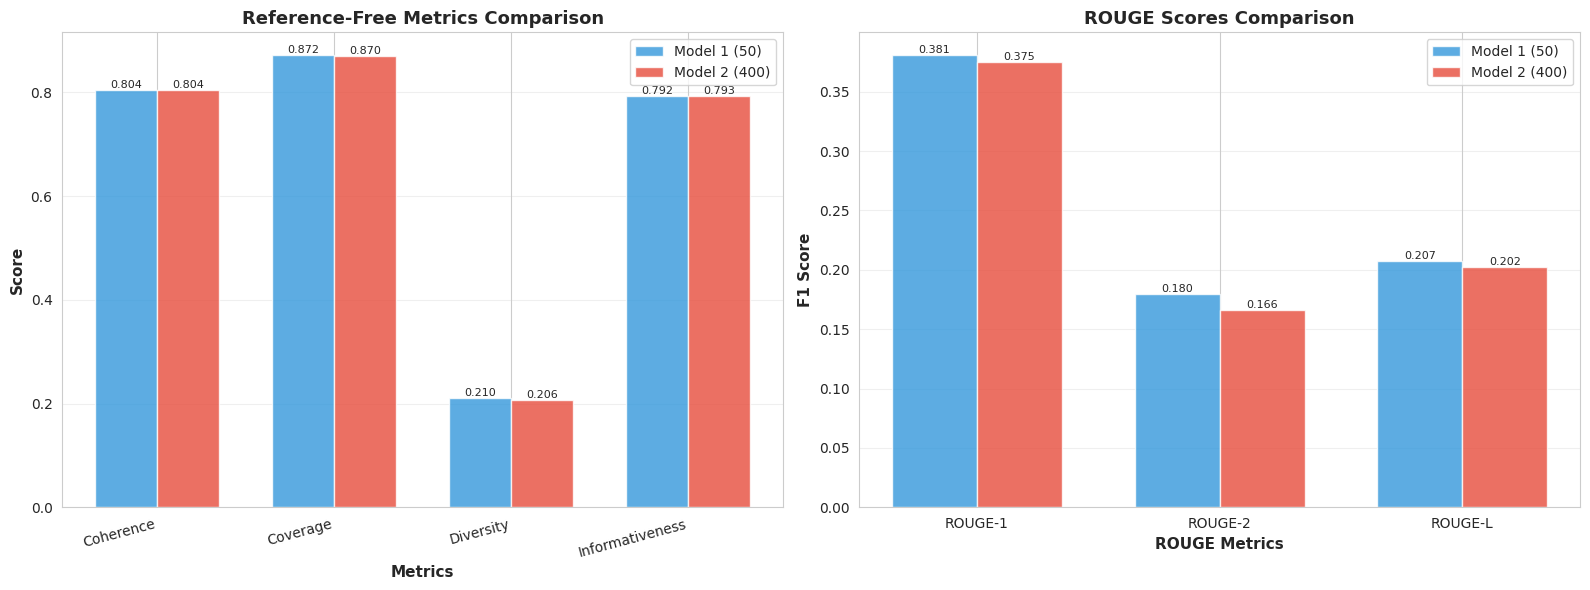

✅ Figure 2 saved as 'figure2_bertscore_radar.png'


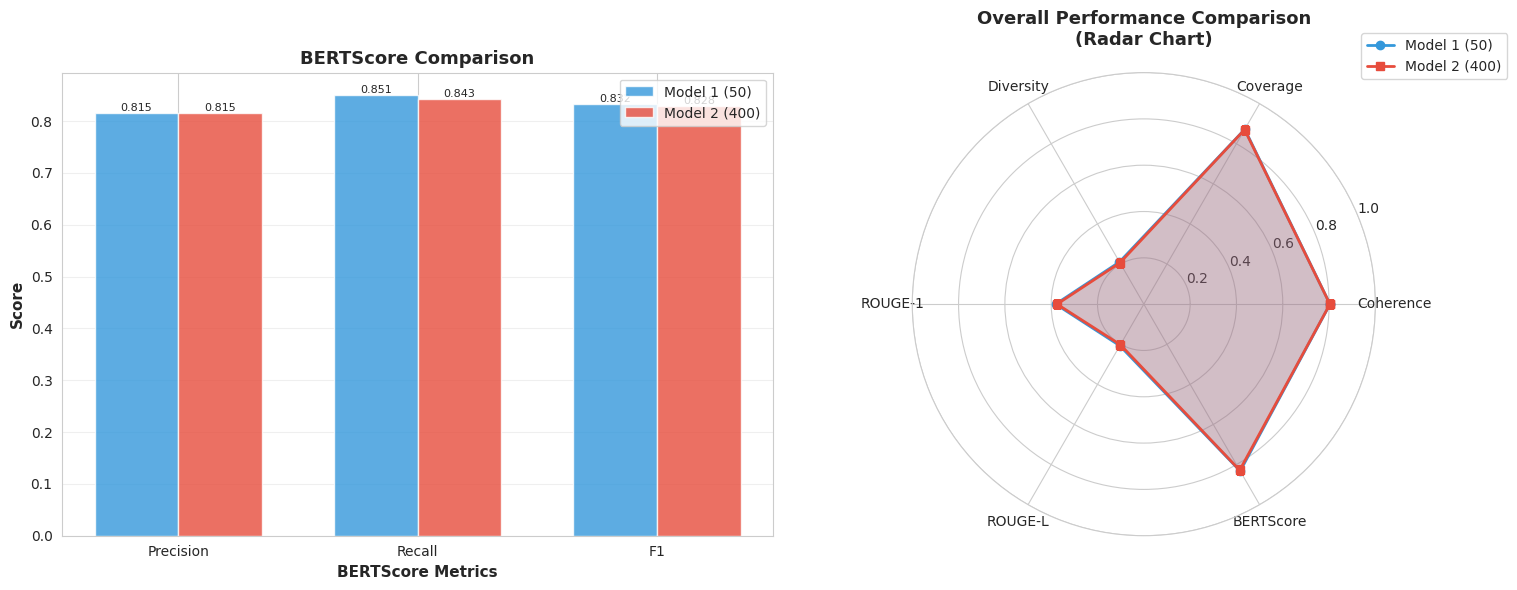

✅ Figure 3 saved as 'figure3_aspects_comparison.png'


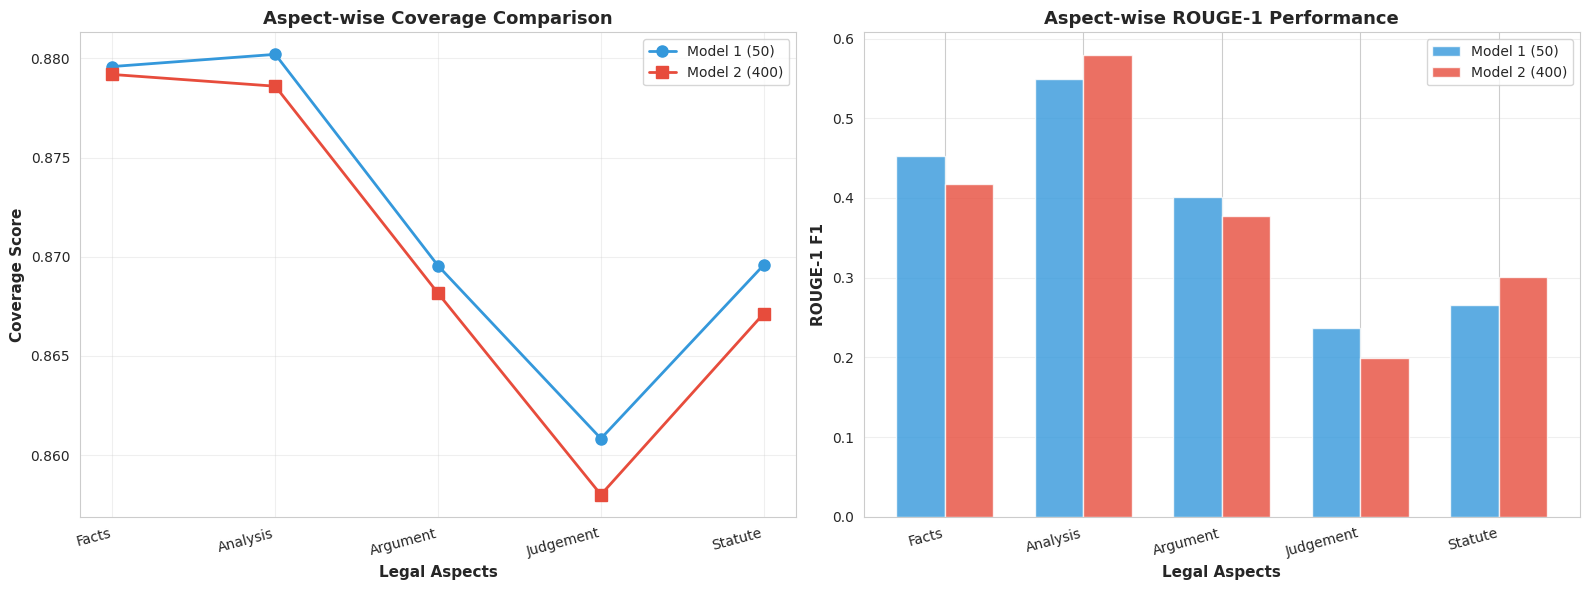


SUMMARY STATISTICS TABLE
           Metric Model 1 (50) Model 2 (400)      Improvement
        Coherence       0.8038        0.8036  -0.0002 (-0.0%)
         Coverage       0.8720        0.8702  -0.0017 (-0.2%)
        Diversity       0.2103        0.2062  -0.0041 (-2.0%)
  Informativeness       0.7923        0.7934    0.0010 (0.1%)
       ROUGE-1 F1       0.3809        0.3748  -0.0061 (-1.6%)
       ROUGE-2 F1       0.1797        0.1658  -0.0138 (-7.7%)
       ROUGE-L F1       0.2073        0.2024  -0.0049 (-2.4%)
             BLEU       0.1102        0.1025  -0.0077 (-7.0%)
      BERTScore P       0.8153        0.8146  -0.0007 (-0.1%)
      BERTScore R       0.8509        0.8426  -0.0083 (-1.0%)
     BERTScore F1       0.8324        0.8281  -0.0042 (-0.5%)
Compression Ratio       0.0902        0.0873  -0.0029 (-3.2%)
       Val Reward       0.6520        0.5808 -0.0713 (-10.9%)

✅ Summary table saved as 'model_comparison_summary.csv'

✅ ALL VISUALIZATIONS COMPLETE!

Generated files:

In [21]:
# Results Visualization - Modified Version
# Creates 3 separate figures with 2 subplots each
# Radar chart and Aspect-wise ROUGE-1 positions swapped

print("\n" + "="*80)
print("GENERATING SEPARATE VISUALIZATIONS")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style
sns.set_style("whitegrid")
width = 0.35

# ============================================================================
# FIGURE 1: Reference-Free Metrics & ROUGE Scores Comparison
# ============================================================================
fig1 = plt.figure(figsize=(16, 6))

# 1. Reference-Free Metrics Comparison (Bar Chart)
ax1 = plt.subplot(1, 2, 1)
metrics_free = ['coherence', 'coverage', 'diversity', 'informativeness']
model1_free = [results_model1['overall_metrics_free'][m] for m in metrics_free]
model2_free = [results_model2['overall_metrics_free'][m] for m in metrics_free]

x = np.arange(len(metrics_free))
bars1 = ax1.bar(x - width/2, model1_free, width, label='Model 1 (50)', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x + width/2, model2_free, width, label='Model 2 (400)', alpha=0.8, color='#e74c3c')

ax1.set_xlabel('Metrics', fontsize=11, fontweight='bold')
ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
ax1.set_title('Reference-Free Metrics Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([m.capitalize() for m in metrics_free], rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. ROUGE Scores Comparison
ax2 = plt.subplot(1, 2, 2)
rouge_metrics = ['rouge1_f', 'rouge2_f', 'rougeL_f']
model1_rouge = [results_model1['overall_metrics_ref'][m] for m in rouge_metrics]
model2_rouge = [results_model2['overall_metrics_ref'][m] for m in rouge_metrics]

x = np.arange(len(rouge_metrics))
bars1 = ax2.bar(x - width/2, model1_rouge, width, label='Model 1 (50)', alpha=0.8, color='#3498db')
bars2 = ax2.bar(x + width/2, model2_rouge, width, label='Model 2 (400)', alpha=0.8, color='#e74c3c')

ax2.set_xlabel('ROUGE Metrics', fontsize=11, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
ax2.set_title('ROUGE Scores Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('figure1_metrics_rouge.png', dpi=300, bbox_inches='tight')
print("\n✅ Figure 1 saved as 'figure1_metrics_rouge.png'")
plt.show()

# ============================================================================
# FIGURE 2: BERTScore & Overall Performance Radar
# ============================================================================
fig2 = plt.figure(figsize=(16, 6))

# 3. BERTScore Comparison
ax3 = plt.subplot(1, 2, 1)
bert_metrics = ['precision', 'recall', 'f1']
model1_bert = [overall_bert1[m] for m in bert_metrics]
model2_bert = [overall_bert2[m] for m in bert_metrics]

x = np.arange(len(bert_metrics))
bars1 = ax3.bar(x - width/2, model1_bert, width, label='Model 1 (50)', alpha=0.8, color='#3498db')
bars2 = ax3.bar(x + width/2, model2_bert, width, label='Model 2 (400)', alpha=0.8, color='#e74c3c')

ax3.set_xlabel('BERTScore Metrics', fontsize=11, fontweight='bold')
ax3.set_ylabel('Score', fontsize=11, fontweight='bold')
ax3.set_title('BERTScore Comparison', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels([m.capitalize() for m in bert_metrics])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 4. Overall Performance Radar Chart (SWAPPED HERE)
ax4 = plt.subplot(1, 2, 2, projection='polar')

radar_metrics = ['Coherence', 'Coverage', 'Diversity', 'ROUGE-1', 'ROUGE-L', 'BERTScore']
model1_radar = [
    results_model1['overall_metrics_free']['coherence'],
    results_model1['overall_metrics_free']['coverage'],
    results_model1['overall_metrics_free']['diversity'],
    results_model1['overall_metrics_ref']['rouge1_f'],
    results_model1['overall_metrics_ref']['rougeL_f'],
    overall_bert1['f1']
]
model2_radar = [
    results_model2['overall_metrics_free']['coherence'],
    results_model2['overall_metrics_free']['coverage'],
    results_model2['overall_metrics_free']['diversity'],
    results_model2['overall_metrics_ref']['rouge1_f'],
    results_model2['overall_metrics_ref']['rougeL_f'],
    overall_bert2['f1']
]

angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False)
model1_radar += model1_radar[:1]
model2_radar += model2_radar[:1]
angles = np.concatenate((angles, [angles[0]]))

ax4.plot(angles, model1_radar, 'o-', linewidth=2, label='Model 1 (50)', color='#3498db')
ax4.fill(angles, model1_radar, alpha=0.25, color='#3498db')
ax4.plot(angles, model2_radar, 's-', linewidth=2, label='Model 2 (400)', color='#e74c3c')
ax4.fill(angles, model2_radar, alpha=0.25, color='#e74c3c')

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(radar_metrics, fontsize=10)
ax4.set_ylim(0, 1)
ax4.set_title('Overall Performance Comparison\n(Radar Chart)', fontsize=13, fontweight='bold', pad=20)
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax4.grid(True)

plt.tight_layout()
plt.savefig('figure2_bertscore_radar.png', dpi=300, bbox_inches='tight')
print("✅ Figure 2 saved as 'figure2_bertscore_radar.png'")
plt.show()

# ============================================================================
# FIGURE 3: Aspect-wise Coverage & Aspect-wise ROUGE-1
# ============================================================================
fig3 = plt.figure(figsize=(16, 6))

# 5. Aspect-wise Coverage Comparison (Line Plot)
ax5 = plt.subplot(1, 2, 1)
aspects = ['facts', 'analysis', 'argument', 'judgement', 'statute']
model1_aspect_cov = [results_model1['aspect_metrics_free'][a]['coverage'] 
                     for a in aspects if a in results_model1['aspect_metrics_free']]
model2_aspect_cov = [results_model2['aspect_metrics_free'][a]['coverage'] 
                     for a in aspects if a in results_model2['aspect_metrics_free']]

ax5.plot(aspects, model1_aspect_cov, marker='o', linewidth=2, markersize=8, 
         label='Model 1 (50)', color='#3498db')
ax5.plot(aspects, model2_aspect_cov, marker='s', linewidth=2, markersize=8, 
         label='Model 2 (400)', color='#e74c3c')

ax5.set_xlabel('Legal Aspects', fontsize=11, fontweight='bold')
ax5.set_ylabel('Coverage Score', fontsize=11, fontweight='bold')
ax5.set_title('Aspect-wise Coverage Comparison', fontsize=13, fontweight='bold')
ax5.set_xticklabels([a.capitalize() for a in aspects], rotation=15, ha='right')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Aspect-wise ROUGE-1 Comparison (SWAPPED HERE)
ax6 = plt.subplot(1, 2, 2)
model1_aspect_rouge = [results_model1['aspect_metrics_ref'][a]['rouge1_f'] 
                       for a in aspects if a in results_model1['aspect_metrics_ref']]
model2_aspect_rouge = [results_model2['aspect_metrics_ref'][a]['rouge1_f'] 
                       for a in aspects if a in results_model2['aspect_metrics_ref']]

x = np.arange(len(aspects))
bars1 = ax6.bar(x - width/2, model1_aspect_rouge, width, label='Model 1 (50)', alpha=0.8, color='#3498db')
bars2 = ax6.bar(x + width/2, model2_aspect_rouge, width, label='Model 2 (400)', alpha=0.8, color='#e74c3c')

ax6.set_xlabel('Legal Aspects', fontsize=11, fontweight='bold')
ax6.set_ylabel('ROUGE-1 F1', fontsize=11, fontweight='bold')
ax6.set_title('Aspect-wise ROUGE-1 Performance', fontsize=13, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels([a.capitalize() for a in aspects], rotation=15, ha='right')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure3_aspects_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Figure 3 saved as 'figure3_aspects_comparison.png'")
plt.show()

# ============================================================================
# Summary Statistics Table
# ============================================================================
print("\n" + "="*80)
print("SUMMARY STATISTICS TABLE")
print("="*80)

summary_data = {
    'Metric': [
        'Coherence', 'Coverage', 'Diversity', 'Informativeness',
        'ROUGE-1 F1', 'ROUGE-2 F1', 'ROUGE-L F1', 'BLEU',
        'BERTScore P', 'BERTScore R', 'BERTScore F1',
        'Compression Ratio', 'Val Reward'
    ],
    'Model 1 (50)': [
        results_model1['overall_metrics_free']['coherence'],
        results_model1['overall_metrics_free']['coverage'],
        results_model1['overall_metrics_free']['diversity'],
        results_model1['overall_metrics_free']['informativeness'],
        results_model1['overall_metrics_ref']['rouge1_f'],
        results_model1['overall_metrics_ref']['rouge2_f'],
        results_model1['overall_metrics_ref']['rougeL_f'],
        results_model1['overall_metrics_ref']['bleu'],
        overall_bert1['precision'],
        overall_bert1['recall'],
        overall_bert1['f1'],
        results_model1['overall_metrics_free']['compression'],
        results_model1['val_reward']
    ],
    'Model 2 (400)': [
        results_model2['overall_metrics_free']['coherence'],
        results_model2['overall_metrics_free']['coverage'],
        results_model2['overall_metrics_free']['diversity'],
        results_model2['overall_metrics_free']['informativeness'],
        results_model2['overall_metrics_ref']['rouge1_f'],
        results_model2['overall_metrics_ref']['rouge2_f'],
        results_model2['overall_metrics_ref']['rougeL_f'],
        results_model2['overall_metrics_ref']['bleu'],
        overall_bert2['precision'],
        overall_bert2['recall'],
        overall_bert2['f1'],
        results_model2['overall_metrics_free']['compression'],
        results_model2['val_reward']
    ]
}

summary_data['Improvement'] = [
    f"{(m2-m1):.4f} ({((m2-m1)/m1)*100:.1f}%)" 
    for m1, m2 in zip(summary_data['Model 1 (50)'], summary_data['Model 2 (400)'])
]

df_summary = pd.DataFrame(summary_data)
df_summary['Model 1 (50)'] = df_summary['Model 1 (50)'].apply(lambda x: f"{x:.4f}")
df_summary['Model 2 (400)'] = df_summary['Model 2 (400)'].apply(lambda x: f"{x:.4f}")

print(df_summary.to_string(index=False))

df_summary.to_csv('model_comparison_summary.csv', index=False)
print("\n✅ Summary table saved as 'model_comparison_summary.csv'")

print("\n" + "="*80)
print("✅ ALL VISUALIZATIONS COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("  1. figure1_metrics_rouge.png - Reference-Free Metrics & ROUGE")
print("  2. figure2_bertscore_radar.png - BERTScore & Overall Radar")
print("  3. figure3_aspects_comparison.png - Coverage & ROUGE-1 Aspects")
print("  4. model_comparison_summary.csv - Summary table")
print("="*80)


In [22]:
# Export Generated Summaries for Analysis
print("\n" + "="*80)
print("EXPORTING GENERATED SUMMARIES")
print("="*80)

import json
from datetime import datetime

def export_summaries_from_model(model_path, test_data, model_name="Model", output_file="summaries.json"):
    """Generate and export summaries from a model to JSON file"""
    print(f"\nGenerating summaries from: {model_name}")
    print("-"*80)
    
    # Load model
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    position_embed_size = checkpoint['policy_state_dict']['position_embedding.weight'].shape[0]
    
    encoder = SentenceEncoder(model_name="law-ai/InLegalBERT", hidden_dim=768)
    policy = MultiAspectPolicyNetwork(
        input_dim=768, hidden_dim=256, num_aspects=5, dropout=0.5,
        max_position=position_embed_size
    )
    policy.load_state_dict(checkpoint['policy_state_dict'])
    agent = UnsupervisedRLAgent(encoder=encoder, policy=policy)
    agent.policy.eval()
    
    # Generate summaries for all test documents
    all_summaries = []
    
    print(f"Processing {len(test_data)} documents...")
    for idx, item in enumerate(tqdm(test_data, desc="Generating summaries")):
        judgment = item['judgment']
        summaries = agent.generate_summaries(judgment)
        
        # Create document summary entry
        doc_summary = {
            'document_id': idx,
            'model_name': model_name,
            'generated_summaries': summaries,
            'reference_summaries': item.get('reference_summaries', {}),
            'judgment_length': len(judgment.split()),
            'timestamp': datetime.now().isoformat()
        }
        
        # Add summary statistics
        summary_stats = {}
        for aspect in agent.aspects:
            if aspect in summaries and summaries[aspect]:
                summary_stats[aspect] = {
                    'length': len(summaries[aspect].split()),
                    'sentences': len(sent_tokenize(summaries[aspect]))
                }
        
        doc_summary['summary_statistics'] = summary_stats
        all_summaries.append(doc_summary)
    
    # Export to JSON
    export_data = {
        'model_info': {
            'model_name': model_name,
            'model_path': model_path,
            'num_documents': len(test_data),
            'aspects': agent.aspects,
            'export_date': datetime.now().isoformat()
        },
        'summaries': all_summaries
    }
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(export_data, f, indent=2, ensure_ascii=False)
    
    print(f"\n✅ Exported {len(all_summaries)} document summaries to: {output_file}")
    
    # Print statistics
    total_summaries = sum(len([s for s in doc['generated_summaries'].values() if s]) 
                         for doc in all_summaries)
    print(f"   Total summaries generated: {total_summaries}")
    print(f"   Average summaries per document: {total_summaries/len(all_summaries):.2f}")
    
    return all_summaries

# Export summaries from Model 1 (50-dataset)
print("\n[1/2] Exporting Model 1 summaries...")
summaries_model1 = export_summaries_from_model(
    model_path="/kaggle/input/models/inlegalbert-50-unsupervised_legal_summarization.pt",
    test_data=test_data,
    model_name="Model 1 (50-dataset InLegalBERT)",
    output_file="summaries_model1_50dataset.json"
)

# Export summaries from Model 2 (400-dataset)
print("\n[2/2] Exporting Model 2 summaries...")
summaries_model2 = export_summaries_from_model(
    model_path="/kaggle/input/models/final_inlegalbert_model.pt",
    test_data=test_data,
    model_name="Model 2 (400-dataset InLegalBERT)",
    output_file="summaries_model2_400dataset.json"
)

# Create comparative export (side-by-side comparison)
print("\n" + "="*80)
print("CREATING COMPARATIVE SUMMARY FILE")
print("="*80)

comparative_data = []
for idx in range(len(test_data)):
    comparison = {
        'document_id': idx,
        'judgment': test_data[idx]['judgment'],
        'judgment_length': len(test_data[idx]['judgment'].split()),
        'model1_summaries': summaries_model1[idx]['generated_summaries'],
        'model2_summaries': summaries_model2[idx]['generated_summaries'],
        'reference_summaries': test_data[idx].get('reference_summaries', {}),
        'comparison_stats': {}
    }
    
    # Add comparative statistics for each aspect
    for aspect in ['facts', 'analysis', 'argument', 'judgement', 'statute']:
        m1_sum = summaries_model1[idx]['generated_summaries'].get(aspect, '')
        m2_sum = summaries_model2[idx]['generated_summaries'].get(aspect, '')
        
        if m1_sum and m2_sum:
            comparison['comparison_stats'][aspect] = {
                'model1_length': len(m1_sum.split()),
                'model2_length': len(m2_sum.split()),
                'length_difference': len(m2_sum.split()) - len(m1_sum.split())
            }
    
    comparative_data.append(comparison)

# Export comparative data
comparative_export = {
    'metadata': {
        'num_documents': len(test_data),
        'model1': 'Model 1 (50-dataset InLegalBERT)',
        'model2': 'Model 2 (400-dataset InLegalBERT)',
        'export_date': datetime.now().isoformat()
    },
    'comparisons': comparative_data
}

with open('summaries_comparative.json', 'w', encoding='utf-8') as f:
    json.dump(comparative_export, f, indent=2, ensure_ascii=False)

print("✅ Comparative summaries exported to: summaries_comparative.json")

# Create human-readable text file for easy review
print("\n" + "="*80)
print("CREATING HUMAN-READABLE SUMMARY FILE")
print("="*80)

with open('summaries_readable.txt', 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write("LEGAL JUDGMENT SUMMARIES - MODEL COMPARISON\n")
    f.write("="*100 + "\n\n")
    
    for idx, comp in enumerate(comparative_data[:5]):  # Show first 5 documents as sample
        f.write(f"\n{'='*100}\n")
        f.write(f"DOCUMENT {idx + 1}\n")
        f.write(f"{'='*100}\n")
        f.write(f"Judgment Length: {comp['judgment_length']} words\n\n")
        
        for aspect in ['facts', 'analysis', 'argument', 'judgement', 'statute']:
            f.write(f"\n{'-'*100}\n")
            f.write(f"ASPECT: {aspect.upper()}\n")
            f.write(f"{'-'*100}\n")
            
            # Reference summary
            ref_sum = comp['reference_summaries'].get(aspect, '')
            if ref_sum:
                f.write(f"\n[REFERENCE SUMMARY]\n{ref_sum}\n")
            
            # Model 1 summary
            m1_sum = comp['model1_summaries'].get(aspect, '')
            if m1_sum:
                f.write(f"\n[MODEL 1 - 50 dataset] ({len(m1_sum.split())} words)\n{m1_sum}\n")
            
            # Model 2 summary
            m2_sum = comp['model2_summaries'].get(aspect, '')
            if m2_sum:
                f.write(f"\n[MODEL 2 - 400 dataset] ({len(m2_sum.split())} words)\n{m2_sum}\n")
        
        f.write("\n" + "="*100 + "\n\n")
    
    f.write(f"\n\n(Showing 5 of {len(comparative_data)} documents. Full data available in JSON files.)\n")

print("✅ Human-readable summaries exported to: summaries_readable.txt")

# Summary statistics
print("\n" + "="*80)
print("EXPORT SUMMARY")
print("="*80)
print(f"\n📁 Files created:")
print(f"   1. summaries_model1_50dataset.json      - All Model 1 summaries")
print(f"   2. summaries_model2_400dataset.json     - All Model 2 summaries")
print(f"   3. summaries_comparative.json           - Side-by-side comparison")
print(f"   4. summaries_readable.txt               - Human-readable format (sample)")
print(f"\n📊 Documents processed: {len(test_data)}")
print(f"🎯 Aspects covered: facts, analysis, argument, judgement, statute")

print("\n" + "="*80)
print("✅ ALL SUMMARIES EXPORTED SUCCESSFULLY!")
print("="*80)



EXPORTING GENERATED SUMMARIES

[1/2] Exporting Model 1 summaries...

Generating summaries from: Model 1 (50-dataset InLegalBERT)
--------------------------------------------------------------------------------
Processing 20 documents...


Generating summaries: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]



✅ Exported 20 document summaries to: summaries_model1_50dataset.json
   Total summaries generated: 100
   Average summaries per document: 5.00

[2/2] Exporting Model 2 summaries...

Generating summaries from: Model 2 (400-dataset InLegalBERT)
--------------------------------------------------------------------------------
Processing 20 documents...


Generating summaries: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


✅ Exported 20 document summaries to: summaries_model2_400dataset.json
   Total summaries generated: 100
   Average summaries per document: 5.00

CREATING COMPARATIVE SUMMARY FILE
✅ Comparative summaries exported to: summaries_comparative.json

CREATING HUMAN-READABLE SUMMARY FILE
✅ Human-readable summaries exported to: summaries_readable.txt

EXPORT SUMMARY

📁 Files created:
   1. summaries_model1_50dataset.json      - All Model 1 summaries
   2. summaries_model2_400dataset.json     - All Model 2 summaries
   3. summaries_comparative.json           - Side-by-side comparison
   4. summaries_readable.txt               - Human-readable format (sample)

📊 Documents processed: 20
🎯 Aspects covered: facts, analysis, argument, judgement, statute

✅ ALL SUMMARIES EXPORTED SUCCESSFULLY!
